In [1]:
import pandas as pd
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row

In [2]:
accidents = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_42724\901670543.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("../PrometneNesreče.csv")


In [3]:
# Priprava podatkov
accidents['NastanekDatumCas'] = pd.to_datetime(accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
print(f"NastanekDatumCas column dtype: {accidents['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns]


# CosinorPy - jesen

In [4]:
autumn_mask = accidents['NastanekDatumCas'].dt.month.isin([9, 10, 11])

autumn_accidents = accidents[autumn_mask]
# print(f"NastanekDatumCas column dtype: {autumn_accidents['NastanekDatumCas'].dtype}")

hours = autumn_accidents['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsAutumn",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

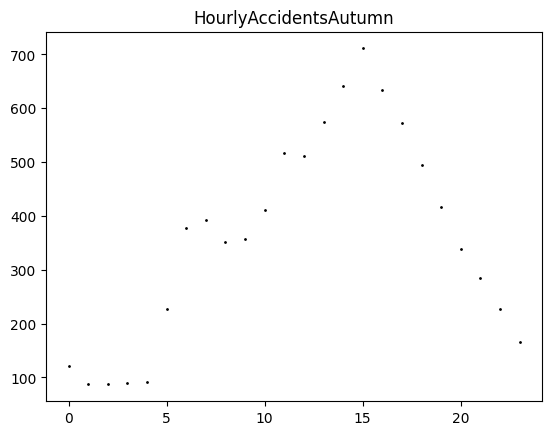

In [5]:
cosinor.plot_data(df_plot, names=["HourlyAccidentsAutumn"])

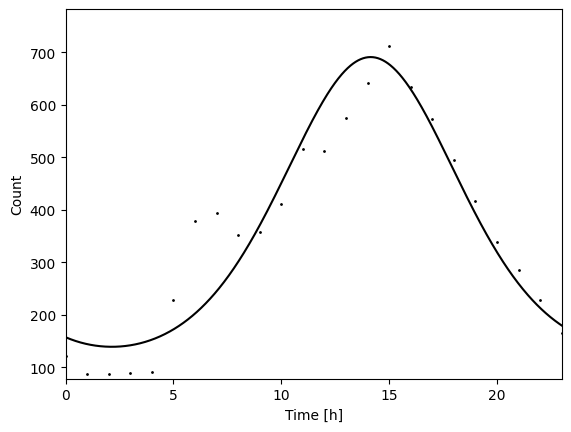

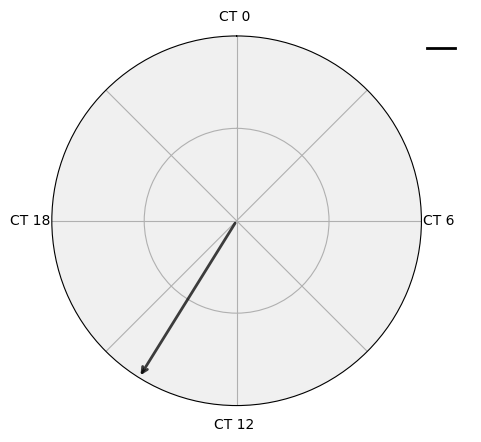

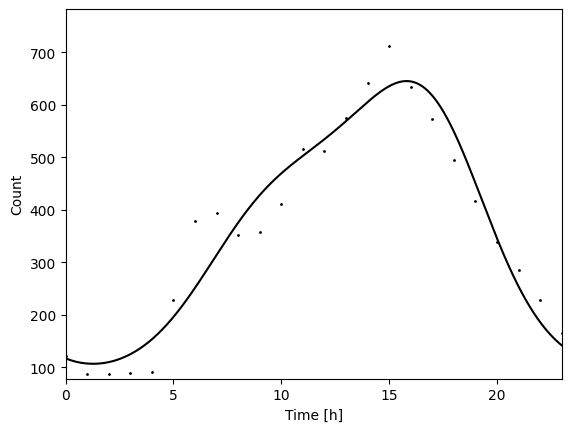

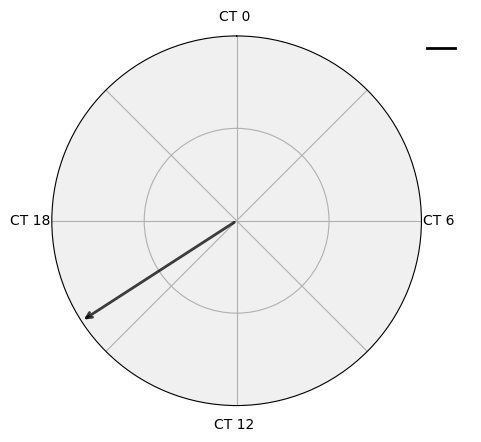

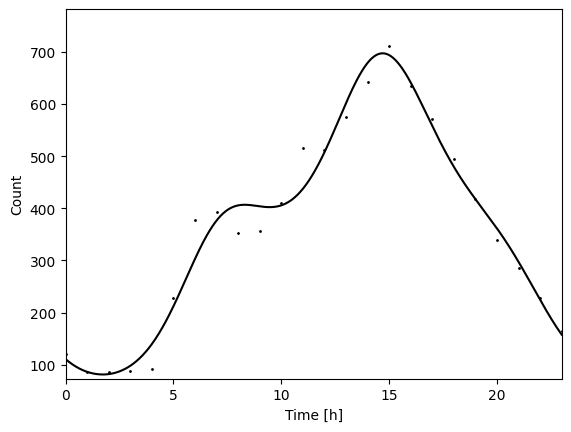

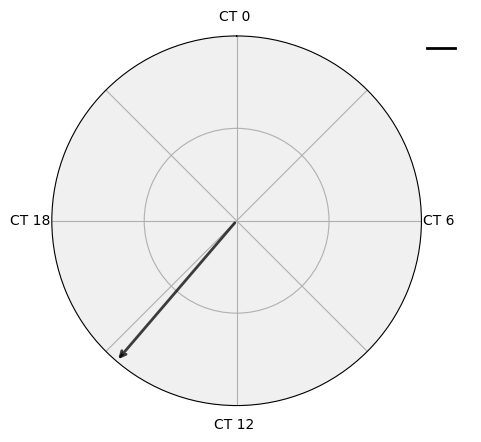

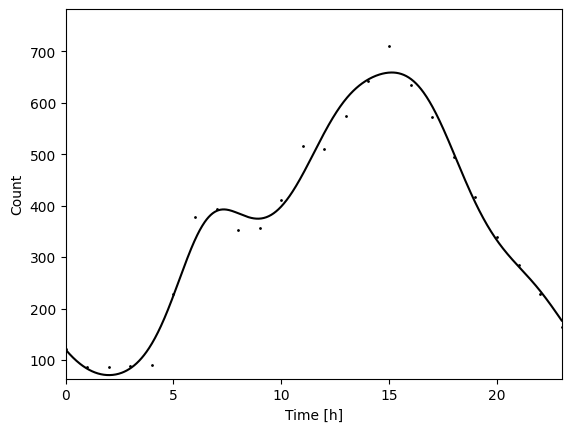

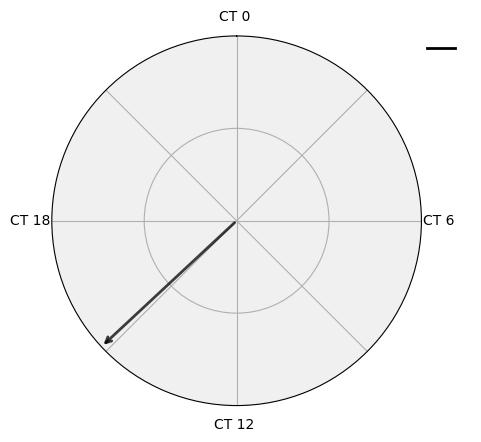

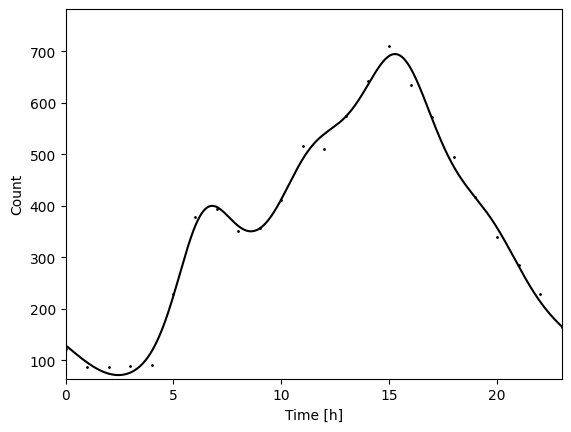

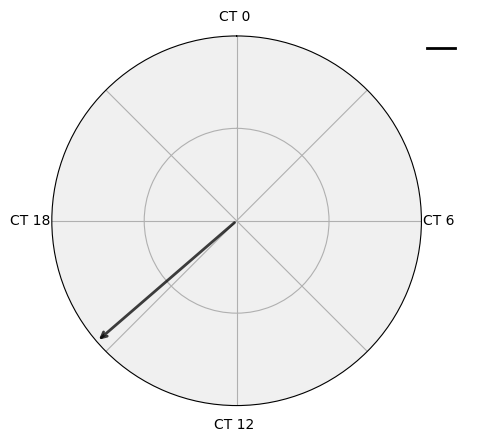

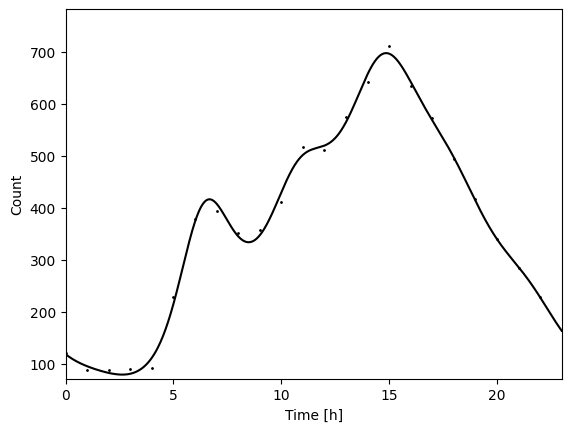

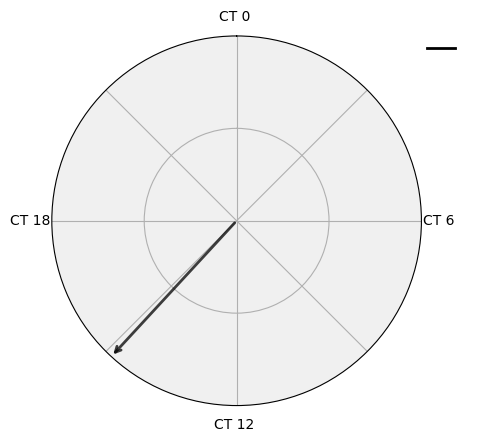

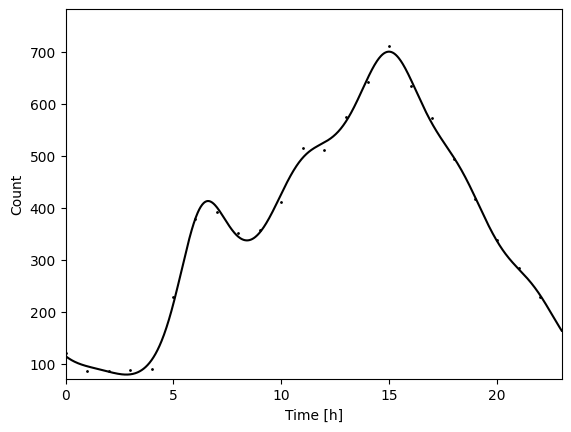

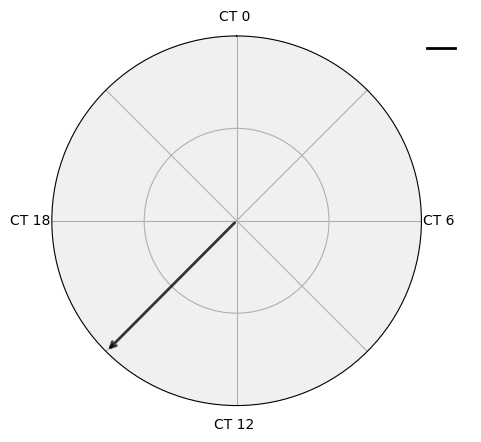

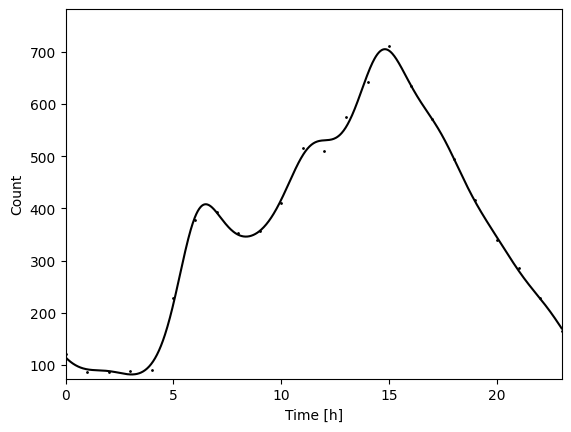

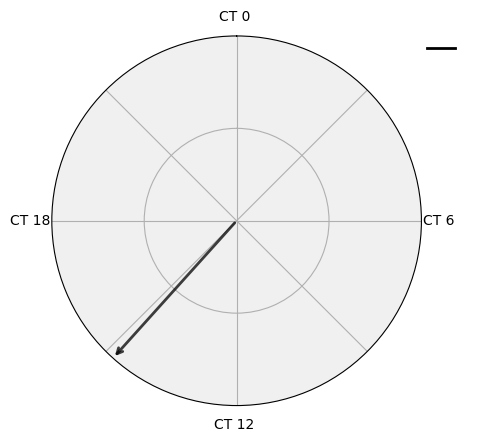

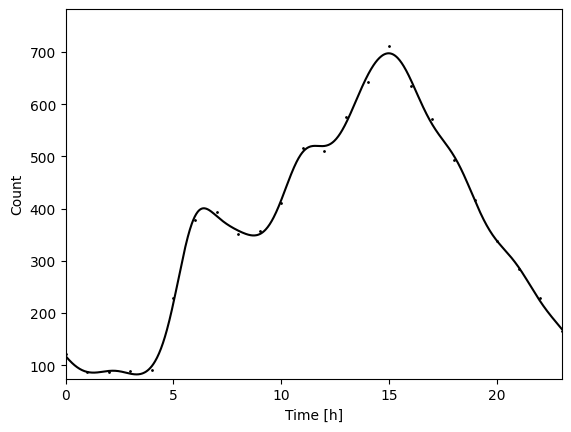

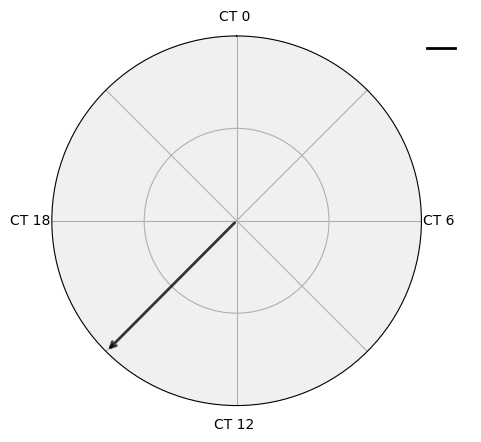

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


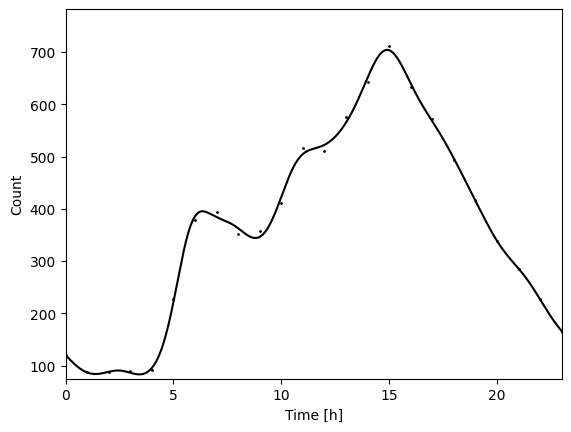

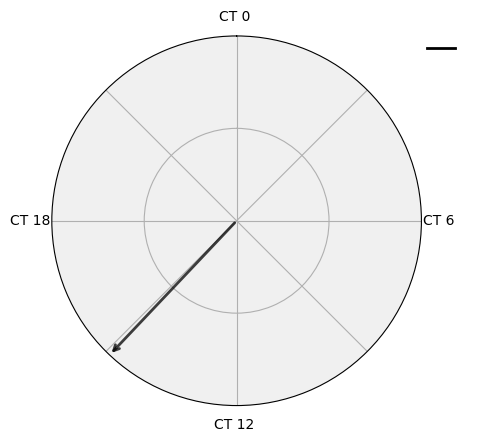

In [6]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsAutumn', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [8]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsAutumn,24.0,1.0,1.779015e-12,1.779015e-12,99102.892703,-134.438166,0.167530,275.844313,2.584974,414.957619,[14.126126126126126],[690.7981043394751],[2.1621621621621623],[139.1147405175421]
1,HourlyAccidentsAutumn,24.0,2.0,3.802555e-14,4.225061e-14,55870.889876,-127.023945,0.213441,269.180581,2.144711,375.922759,[15.807807807807807],[645.1033396276002],[1.2492492492492493],[106.74533002596466]
2,HourlyAccidentsAutumn,24.0,3.0,2.022788e-17,2.528485e-17,23534.190339,-116.070779,0.281265,307.988292,2.434027,389.362256,"[8.312312312312311, 14.702702702702702]","[406.8738107489323, 697.350547158053]",[1.7297297297297298],[81.37396411103362]
3,HourlyAccidentsAutumn,24.0,4.0,1.095824e-18,1.565464e-18,14288.866540,-110.049545,0.318550,294.163926,2.320816,364.704828,"[7.351351351351351, 15.135135135135135]","[392.6508750943803, 658.8687540612775]",[2.018018018018018],[70.5409015051678]
4,HourlyAccidentsAutumn,24.0,5.0,3.139748e-21,5.232914e-21,5534.414460,-100.982583,0.374694,311.809691,2.283079,383.016174,"[6.774774774774775, 15.27927927927928]","[399.88865280354787, 694.8258653923541]","[2.4504504504504503, 8.6006006006006]","[71.20648336297617, 350.4335270121461]"
5,HourlyAccidentsAutumn,24.0,6.0,7.525564e-24,1.881391e-23,2414.277096,-91.738758,0.431934,309.227632,2.396290,388.258659,"[6.678678678678678, 14.846846846846846]","[416.26186238833526, 697.4792447117708]","[2.6426426426426426, 8.504504504504505]","[79.03420826898552, 333.7084575943512]"
6,HourlyAccidentsAutumn,24.0,7.0,2.136296e-23,4.272591e-23,2198.441634,-90.183256,0.441566,310.394254,2.358553,389.973969,"[6.5825825825825826, 14.99099099099099]","[413.174437688774, 700.3682229868563]","[2.834834834834835, 8.408408408408409]","[79.58560873868959, 337.5052369789528]"
7,HourlyAccidentsAutumn,24.0,8.0,4.395088e-24,1.465029e-23,1805.318495,-85.859773,0.468338,311.809573,2.408869,393.459935,"[6.486486486486487, 14.7987987987988]","[407.99125767906696, 705.2695080925275]","[3.075075075075075, 8.36036036036036]","[81.65588886005804, 345.9578116083527]"
8,HourlyAccidentsAutumn,24.0,9.0,2.707734e-25,1.353867e-24,1398.962618,-80.247154,0.503092,307.445816,2.358553,390.093177,"[6.39039039039039, 11.57957957957958, 14.99099...","[400.7335456287621, 520.2648731722311, 697.536...","[1.2972972972972974, 3.2672672672672673, 8.696...","[86.04458147334654, 82.65481299201143, 348.689..."
9,HourlyAccidentsAutumn,24.0,10.0,1.055473e-25,1.055473e-24,1129.649214,-76.713070,0.524976,310.479396,2.383711,393.557321,"[6.342342342342342, 14.894894894894895]","[395.21781099605573, 704.0304844228021]","[1.3933933933933933, 3.4114114114114114, 8.792...","[83.77312630821014, 83.07792521006688, 344.077..."


### Katero je najboljše število komponent

In [9]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsAutumn,24.0,6.0,7.525564e-24,1.881391e-23,2414.277096,-91.738758,0.431934,309.227632,2.39629,388.258659,"[6.678678678678678, 14.846846846846846]","[416.26186238833526, 697.4792447117708]","[2.6426426426426426, 8.504504504504505]","[79.03420826898552, 333.7084575943512]"


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


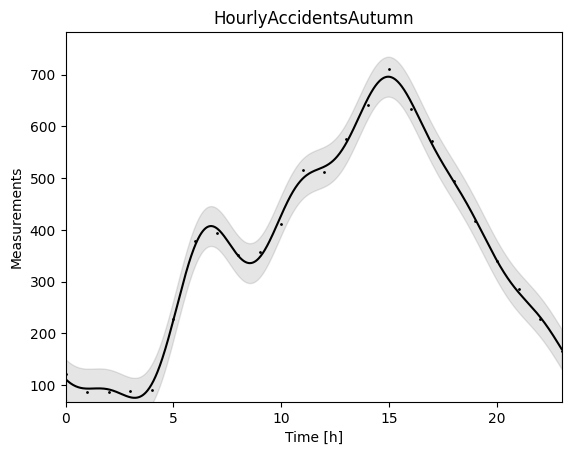

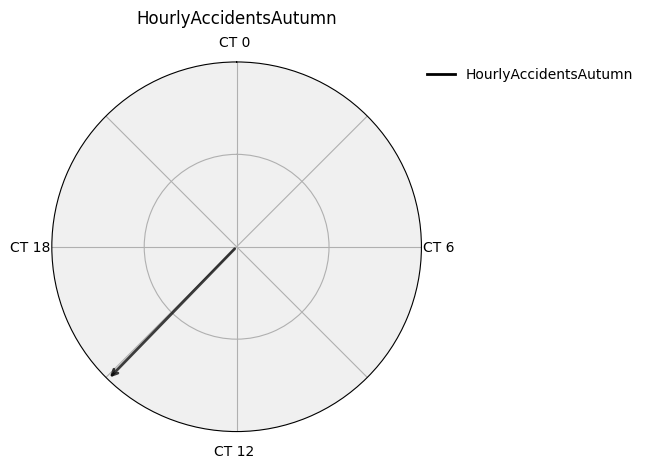

In [10]:
cosinor.plot_df_models(df_plot, df_best_model)